In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# unzip dataset
!unzip hymenoptera_data.zip

In [2]:
# torchinfo summary
!pip install torchinfo
from torchinfo import summary

## Load Data

In [3]:
# data augmentation, in dict
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# datasets and dataloaders
data_dir = r'hymenoptera_data'

# dataloader, in dict
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=1)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [6]:
# agnostic code
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Image visualization

In [7]:
def imshow(inp, title=None):
  """Display tensor image"""
  inp = inp.numpy().transpose((1, 2, 0))    # color channels

  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)

  plt.imshow(inp)
  if title is not None:
    plt.title(title)

  plt.pause(0.001)    # update plots

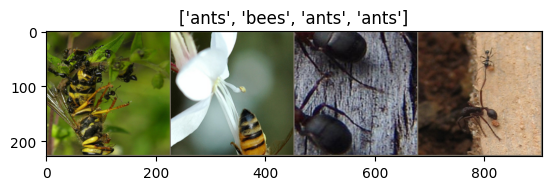

In [8]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Training

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  # create temporary to save training chekpoints
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pth')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    # begin training
    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)

      for phase in ['train', 'val']:    # train & validation
        if phase == 'train':
          model.train()
        else:
          model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          # Context-manager that sets gradient calculation on or off
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model (update best model)
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), best_model_params_path)
      print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

  return model

## Visualizing model predictions

In [10]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure

  with torch.inference_mode():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return

    model.train(mode=was_training)

## Finetuning ConvNet

In [11]:
# resnet
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# modeify classifier
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

# loss fn, optimizer, lr_scheduler
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:05<00:00, 8.15MB/s]


In [12]:
# training
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5759 Acc: 0.7008
val Loss: 0.2048 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4513 Acc: 0.7951
val Loss: 0.5806 Acc: 0.7516

Epoch 2/24
----------
train Loss: 0.6053 Acc: 0.7623
val Loss: 0.3123 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.5073 Acc: 0.8074
val Loss: 0.2214 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.6006 Acc: 0.7910
val Loss: 0.5678 Acc: 0.8235

Epoch 5/24
----------
train Loss: 0.6624 Acc: 0.7541
val Loss: 0.3416 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.4727 Acc: 0.8279
val Loss: 0.3853 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3425 Acc: 0.8607
val Loss: 0.3217 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3532 Acc: 0.8525
val Loss: 0.3102 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.2482 Acc: 0.9016
val Loss: 0.2831 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3073 Acc: 0.8525
val Loss: 0.2918 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3346 Acc: 0.8689
val Loss: 0.2802 Acc: 0.9085

Ep

In [14]:
# torchinfo summary
summary(model_ft, (1, 3, 224, 224), col_width=20,
        col_names=["kernel_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                  Kernel Shape         Output Shape         Param #              Trainable
ResNet (ResNet)                          --                   [1, 2]               --                   True
├─Conv2d (conv1)                         [7, 7]               [1, 64, 112, 112]    9,408                True
├─BatchNorm2d (bn1)                      --                   [1, 64, 112, 112]    128                  True
├─ReLU (relu)                            --                   [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    3                    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    --                   [1, 64, 56, 56]      --                   True
│    └─BasicBlock (0)                    --                   [1, 64, 56, 56]      --                   True
│    │    └─Conv2d (conv1)               [3, 3]               [1, 64, 56, 56]      36,864               True
│    │    └─BatchN

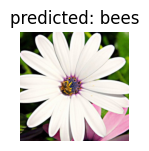

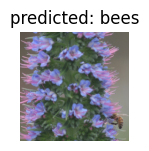

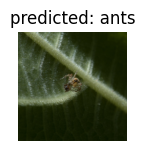

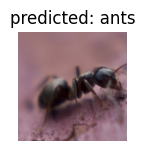

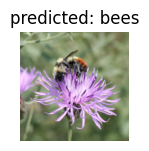

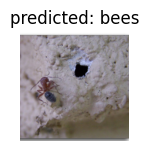

In [15]:
visualize_model(model_ft)

## ConvNet Fixed Feature Extractor

In [16]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# freeze ConvNet
for param in model_conv.parameters():
  param.requires_grad = False

# newly constructed model
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

# agnostic
model_conv = model_conv.to(device)

# loss fn, optimizer, lr_scheduler
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6738 Acc: 0.6311
val Loss: 0.2731 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4113 Acc: 0.7951
val Loss: 0.1667 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.3726 Acc: 0.8279
val Loss: 0.2563 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5260 Acc: 0.7910
val Loss: 0.1740 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4887 Acc: 0.7910
val Loss: 0.2092 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.2977 Acc: 0.8607
val Loss: 0.2639 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.5880 Acc: 0.7623
val Loss: 0.1733 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3448 Acc: 0.8115
val Loss: 0.1827 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2673 Acc: 0.8893
val Loss: 0.1878 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3388 Acc: 0.8279
val Loss: 0.1917 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3887 Acc: 0.8074
val Loss: 0.2501 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3520 Acc: 0.8648
val Loss: 0.1668 Acc: 0.9412

Ep

In [18]:
# torchinfo summary
summary(model_conv, (1, 3, 224, 224), col_width=20,
        col_names=["kernel_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                  Kernel Shape         Output Shape         Param #              Trainable
ResNet (ResNet)                          --                   [1, 2]               --                   Partial
├─Conv2d (conv1)                         [7, 7]               [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      --                   [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            --                   [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    3                    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    --                   [1, 64, 56, 56]      --                   False
│    └─BasicBlock (0)                    --                   [1, 64, 56, 56]      --                   False
│    │    └─Conv2d (conv1)               [3, 3]               [1, 64, 56, 56]      (36,864)             False
│    │    

In [21]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)    # transform
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.inference_mode():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

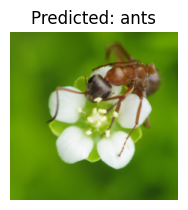

In [25]:
visualize_model_predictions(
    model_conv,
    img_path='hymenoptera_data/val/ants/161292361_c16e0bf57a.jpg'
)